In [1]:
# Cell 1 (The Definitive Install)
!pip install "transformers[torch]>=4.38" "datasets>=2.18" "evaluate>=0.4" scikit-learn pandas

In [6]:
!unzip BBC.zip


Archive:  BBC.zip
   creating: bbc/
   creating: bbc/entertainment/
  inflating: bbc/entertainment/289.txt  
  inflating: bbc/entertainment/262.txt  
  inflating: bbc/entertainment/276.txt  
  inflating: bbc/entertainment/060.txt  
  inflating: bbc/entertainment/074.txt  
  inflating: bbc/entertainment/048.txt  
  inflating: bbc/entertainment/114.txt  
  inflating: bbc/entertainment/100.txt  
  inflating: bbc/entertainment/128.txt  
  inflating: bbc/entertainment/316.txt  
  inflating: bbc/entertainment/302.txt  
  inflating: bbc/entertainment/303.txt  
  inflating: bbc/entertainment/317.txt  
  inflating: bbc/entertainment/129.txt  
  inflating: bbc/entertainment/101.txt  
  inflating: bbc/entertainment/115.txt  
  inflating: bbc/entertainment/049.txt  
  inflating: bbc/entertainment/075.txt  
  inflating: bbc/entertainment/061.txt  
  inflating: bbc/entertainment/277.txt  
  inflating: bbc/entertainment/263.txt  
  inflating: bbc/entertainment/288.txt  
  inflating: bbc/entertainment

In [2]:
# Cell 3: Load data into a pandas DataFrame
import pandas as pd
import os

data_path = 'bbc/'
data = []

# Loop through each category folder
for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        # Loop through each text file
        for filename in os.listdir(category_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(category_path, filename)
                with open(file_path, 'r', encoding='latin-1') as f:
                    text = f.read()
                    # Append a dictionary for this article to our list
                    data.append({'text': text, 'label_name': category})

# Create the DataFrame
df = pd.DataFrame(data)

# IMPORTANT: Shuffle the dataframe to ensure randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Data loaded successfully!")
print("Shape of DataFrame:", df.shape)
print("\nSample of the data:")
print(df.head())
print("\nLabel distribution:")
print(df['label_name'].value_counts())

Data loaded successfully!
Shape of DataFrame: (2225, 2)

Sample of the data:
                                                text     label_name
0  Battered dollar hits another low\n\nThe dollar...       business
1  WMC says Xstrata bid is too low\n\nAustralian ...       business
2  Jamelia's return to the top\n\nR&B star Jameli...  entertainment
3  India widens access to telecoms\n\nIndia has r...       business
4  Hamm bows out for US\n\nWomen's football legen...          sport

Label distribution:
label_name
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [3]:
# Cell 4: Create label mappings and split data
from sklearn.model_selection import train_test_split

# Create a sorted list of unique labels to ensure consistent mapping
labels = sorted(df['label_name'].unique().tolist())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Add the integer 'label' column to our DataFrame
df['label'] = df['label_name'].map(label2id)

print("Label to ID Mapping:")
print(label2id)
print("\nID to Label Mapping:")
print(id2label)

# Split the data: 90% for training, 10% for testing
# 'stratify' ensures that both sets have a similar proportion of each category
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['label']
)

print("\nTrain set size:", len(train_df))
print("Test set size:", len(test_df))

Label to ID Mapping:
{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

ID to Label Mapping:
{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

Train set size: 2002
Test set size: 223


In [4]:
# Cell 5: Convert pandas DataFrames to Hugging Face Datasets
from datasets import Dataset, DatasetDict

# Convert our training and testing DataFrames into Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine them into a single DatasetDict object for easy management
raw_datasets = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# You can inspect the new object
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__'],
        num_rows: 2002
    })
    test: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__'],
        num_rows: 223
    })
})


In [5]:
# Cell 6: Tokenize the datasets
from transformers import AutoTokenizer

# Define the model we are going to fine-tune
model_checkpoint = "distilbert-base-uncased"
# Load its corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Define a function that will apply the tokenizer to a batch of examples
def tokenize_function(examples):
    # The tokenizer will pad shorter texts and truncate longer ones to a standard length
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Use the .map() method to apply this function to all examples in our datasets.
# batched=True makes the process much faster.
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Let's inspect the result. You'll see new columns like 'input_ids' and 'attention_mask'.
print(tokenized_datasets)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2002 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 2002
    })
    test: Dataset({
        features: ['text', 'label_name', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 223
    })
})


In [10]:
# Cell 7 (Bare Bones - Guaranteed to be Compatible)

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# --- 1. Load the pre-trained model ---
# This part is correct and remains the same.
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# --- 2. Define Bare-Minimum Training Arguments ---
# We are removing EVERY optional argument that could cause an error.
# This must be compatible with any version of the library.
training_args = TrainingArguments(
    output_dir="training_output",
    num_train_epochs=3,
    per_device_train_batch_size=16
)

# --- 3. Create a Simplified Trainer ---
# We are REMOVING the compute_metrics function for now.
# We will evaluate manually AFTER training is done.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    # We still provide the test set here for later.
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

# --- 4. Train the model! ---
print("Starting fine-tuning with a simplified configuration...")
trainer.train()
print("Fine-tuning complete!")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-1048246664.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting fine-tuning with a simplified configuration...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ramdevconnect (ramdevconnect-orbital-locker) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


Fine-tuning complete!


Running final evaluation on the test set...



--- Classification Report ---
               precision    recall  f1-score   support

     business       1.00      1.00      1.00        51
entertainment       0.97      1.00      0.99        39
     politics       1.00      0.98      0.99        42
        sport       1.00      1.00      1.00        51
         tech       1.00      1.00      1.00        40

     accuracy                           1.00       223
    macro avg       0.99      1.00      1.00       223
 weighted avg       1.00      1.00      1.00       223


--- Generating Confusion Matrix ---

Confusion matrix saved as finetuned_confusion_matrix.png


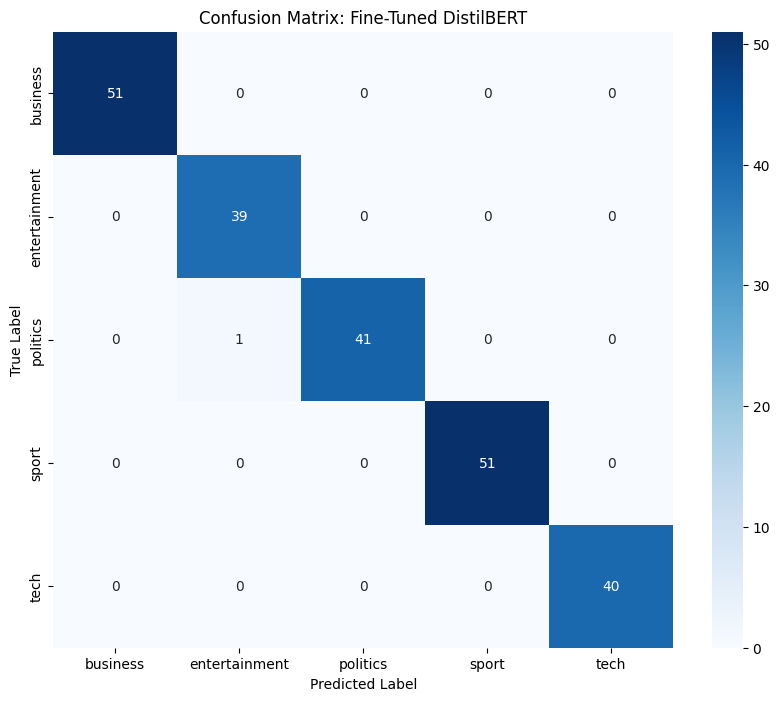

In [11]:
# Cell 8: Final Evaluation

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("Running final evaluation on the test set...")

# Use the trainer to make predictions on our test dataset
predictions_output = trainer.predict(tokenized_datasets["test"])

# The output contains the raw model outputs (logits). We need to find the highest score for each.
predicted_labels = np.argmax(predictions_output.predictions, axis=1)
# These are the correct answers
true_labels = tokenized_datasets["test"]["label"]

# --- Generate Classification Report ---
print("\n--- Classification Report ---")
# We use our `id2label` mapping to show the actual category names
report = classification_report(true_labels, predicted_labels, target_names=[id2label[i] for i in range(len(id2label))])
print(report)


# --- Generate Confusion Matrix ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[id2label[i] for i in range(len(id2label))], yticklabels=[id2label[i] for i in range(len(id2label))])
plt.title('Confusion Matrix: Fine-Tuned DistilBERT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save the plot to the Colab environment
plt.savefig("finetuned_confusion_matrix.png")
print("\nConfusion matrix saved as finetuned_confusion_matrix.png")

In [12]:
# Cell 9: Save Model and Zip Results

# Define a path to save the final model
final_model_path = "bbc-distilbert-finetuned"
# Save the trained model to this path
trainer.save_model(final_model_path)
print(f"Final model saved to '{final_model_path}'")

# Create a single ZIP file containing the model and the confusion matrix image
!zip -r results.zip bbc-distilbert-finetuned finetuned_confusion_matrix.png

print("\nAll artifacts zipped into 'results.zip'. Please download this file.")

Final model saved to 'bbc-distilbert-finetuned'
  adding: bbc-distilbert-finetuned/ (stored 0%)
  adding: bbc-distilbert-finetuned/special_tokens_map.json (deflated 42%)
  adding: bbc-distilbert-finetuned/vocab.txt (deflated 53%)
  adding: bbc-distilbert-finetuned/training_args.bin (deflated 52%)
  adding: bbc-distilbert-finetuned/tokenizer.json (deflated 71%)
  adding: bbc-distilbert-finetuned/model.safetensors (deflated 8%)
  adding: bbc-distilbert-finetuned/tokenizer_config.json (deflated 75%)
  adding: bbc-distilbert-finetuned/config.json (deflated 50%)
  adding: finetuned_confusion_matrix.png (deflated 20%)

All artifacts zipped into 'results.zip'. Please download this file.
